# Tutorial 1: 10x Visium (DLPFC dataset)

Here we present our re-analysis of 151676 sample of the dorsolateral prefrontal cortex (DLPFC) dataset. Maynard et al. has manually annotated DLPFC layers and white matter (WM) based on the morphological features and gene markers.

This tutorial demonstrates how to identify spatial domains on 10x Visium data using STAGATE. The processed data are available at https://github.com/LieberInstitute/spatialLIBD. We downloaded the manual annotation from the spatialLIBD package and provided at https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [3]:
from sklearn.metrics.cluster import adjusted_rand_score

In [4]:
# sys.path.append('/home/lytq/STAGATE/STAGATE_torch/STAGATE_pyG')

In [5]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

print(TORCH_version, TORCH)
print(CUDA_version, CUDA)

2.0.1+cu118 2.0.1
11.8 cu118


In [6]:
# !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-geometric

In [7]:
import STAGATE_pyG as STAGATE

In [8]:
import rpy2
print(rpy2.__file__)

/home/lytq/.conda/envs/stagate/lib/python3.10/site-packages/rpy2/__init__.py


In [9]:
# the location of R (used for the mclust clustering)
os.environ['R_HOME'] = '/home/lytq/.conda/envs/stagate/lib/R'
os.environ['R_USER'] = '/.conda/envs/stagate/lib/python3.10/site-packages/rpy2'

In [10]:
section_id = '151676'
data_dir = '/home/lytq/STAGATE/data/DLPFC_new'

In [11]:
input_dir = os.path.join(data_dir, section_id)
adata = sc.read_visium(path=input_dir, count_file='filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

In [12]:
adata

AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [13]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)  
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [14]:
# read the annotation
Ann_df = pd.read_csv(os.path.join(data_dir, section_id, 'metadata.tsv'), sep='\t', index_col=0)
Ann_df['Ground Truth'] = Ann_df['layer_guess']

In [15]:
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

In [16]:
adata.obs['Ground Truth']

AAACAAGTATCTCCCA-1    Layer3
AAACAATCTACTAGCA-1    Layer1
AAACACCAATAACTGC-1        WM
AAACAGAGCGACTCCT-1    Layer3
AAACAGGGTCTATATT-1    Layer6
                       ...  
TTGTTGTGTGTCAAGA-1    Layer6
TTGTTTCACATCCAGG-1        WM
TTGTTTCATTAGTCTA-1        WM
TTGTTTCCATACAACT-1    Layer6
TTGTTTGTGTAAATTC-1    Layer1
Name: Ground Truth, Length: 3460, dtype: object

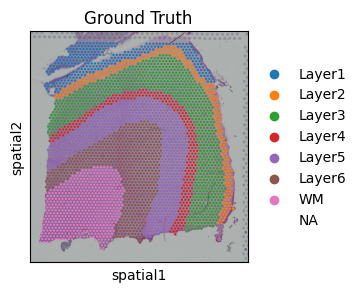

In [17]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

## Constructing the spatial network

------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.


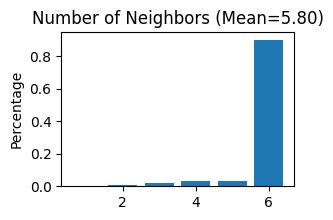

In [18]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=150)
STAGATE.Stats_Spatial_Net(adata)

## Running STAGATE

In [19]:
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')

In [20]:
adata

AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'Ground Truth_colors', 'Spatial_Net'
    obsm: 'spatial'

In [21]:
type(adata.X)

scipy.sparse._csr.csr_matrix

In [22]:
print(adata.X.shape)
print(adata.X.todense().shape)

(3460, 33538)


(3460, 33538)


In [23]:
adata = STAGATE.train_STAGATE(adata, device=device)

Size of Input:  (3460, 3000)


100%|██████████| 1000/1000 [00:06<00:00, 162.23it/s]


In [24]:
adata

AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'Ground Truth_colors', 'Spatial_Net'
    obsm: 'spatial', 'STAGATE'

In [25]:
# import rpy2.robjects.packages as rpackages
# from rpy2.robjects.vectors import StrVector

# # set R package names
# packnames = ('mclust',)

# # import R's utility package
# utils = rpackages.importr('utils')

# utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# # list and install missing packages
# packnames_to_install = [x for x in packnames if not rpackages.isinstalled(x)]

# if len(packnames_to_install) > 0:
#     utils.install_packages(StrVector(packnames_to_install))

In [26]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
adata = STAGATE.mclust_R(adata, used_obsm='STAGATE', num_cluster=7)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [27]:
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
print('Adjusted rand index = %.2f' %ARI)

Adjusted rand index = 0.44


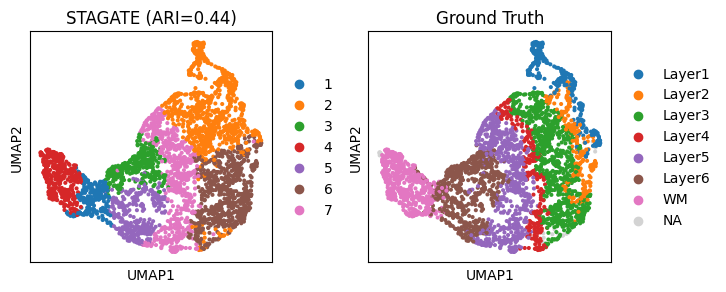

In [28]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color=["mclust", "Ground Truth"], title=['STAGATE (ARI=%.2f)'%ARI, "Ground Truth"])

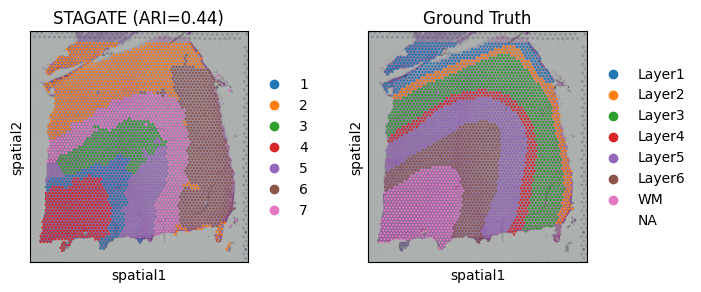

In [29]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, color=["mclust", "Ground Truth"], title=['STAGATE (ARI=%.2f)'%ARI, "Ground Truth"])

## Spatial trajectory inference (PAGA)

In [30]:
adata

AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth', 'mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'Ground Truth_colors', 'Spatial_Net', 'neighbors', 'umap', 'mclust_colors'
    obsm: 'spatial', 'STAGATE', 'X_umap'
    obsp: 'distances', 'connectivities'

In [31]:
adata.obsm['STAGATE'].shape

(3460, 30)

In [32]:
used_adata = adata[adata.obs['Ground Truth']!='nan',]
used_adata

View of AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth', 'mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'Ground Truth_colors', 'Spatial_Net', 'neighbors', 'umap', 'mclust_colors'
    obsm: 'spatial', 'STAGATE', 'X_umap'
    obsp: 'distances', 'connectivities'

In [33]:
# Remove 'nan' values from 'Ground Truth' column
used_adata = used_adata[~used_adata.obs['Ground Truth'].isna()]

# Run PAGA
sc.tl.paga(used_adata, groups='Ground Truth')

In [34]:
adata

AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth', 'mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'Ground Truth_colors', 'Spatial_Net', 'neighbors', 'umap', 'mclust_colors'
    obsm: 'spatial', 'STAGATE', 'X_umap'
    obsp: 'distances', 'connectivities'

[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

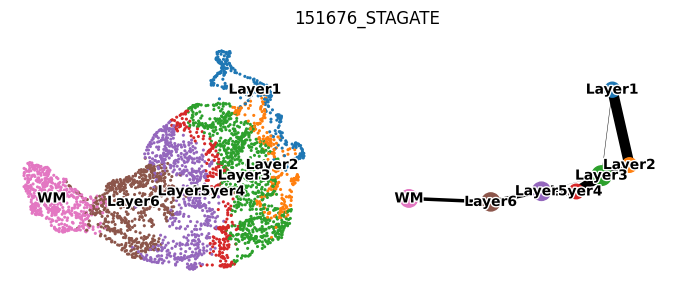

In [35]:
plt.rcParams["figure.figsize"] = (4,3)
sc.pl.paga_compare(used_adata, legend_fontsize=10, frameon=False, size=20,
                   title=section_id+'_STAGATE', legend_fontoutline=2, show=False)